# Checks for running this notebook in colab

In [1]:
#Check if colab is running
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    %tensorflow_version 2.x
    
#import TF  
import tensorflow as tf
from platform import python_version
print("Tensorflow version", tf.__version__)
print("Python version =",python_version())

Tensorflow version 2.5.0
Python version = 3.7.11


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# If you want to load the results stored in hdf5 files:
#!pip install --upgrade tables

     |████████████████████████████████| 4.3MB 9.2MB/s 
  Found existing installation: tables 3.4.4
    Uninstalling tables-3.4.4:
      Successfully uninstalled tables-3.4.4


# Input

In [4]:
import h5py
import numpy as np
np.random.seed(1338)

from sklearn.model_selection import train_test_split

import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

plt.rcParams.update({
    "figure.constrained_layout.use" : True,
    "font.size" : 14,
    "figure.figsize" : (7, 5)
})

In [5]:
drive_path = "drive/MyDrive/project_Flowers-299/data/"
local_path = "data/"

# set path = drive path for running in colabs
# set path = local_path for running locally in git repository
path = drive_path

flowers = [
    "BeeBalm",
    "Black-eyedSusan",
    "BlanketFlower",
    "BleedingHeart",
    "ButterflyBush",
    "Dahlia",
    "FrangipaniFlower",
    "GrapeHyacinth",
    "MargueriteDaisy",
    "Trillium",
    "Waterlilies"
]
img_rows = 200
img_cols = 200
shape_ord = (img_rows, img_cols, 3)


with h5py.File(path + "images_resized_train.h5", "r") as file:
    X = np.array(file["/images"]).astype("float32")
    y = np.array(file["/labels"]).astype("uint8")
    
X.shape, y.shape

((3122, 200, 200, 3), (3122,))

In [6]:
from tensorflow.keras.utils import to_categorical

num_classes = len(np.unique(y))
y = to_categorical(y, num_classes)

print(y[0])
print("Für die einzelnen Klassen sind so viele Instanzen im Datensatz:\n", 
      flowers, "\n", np.sum(y, axis=0))

[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Für die einzelnen Klassen sind so viele Instanzen im Datensatz:
 ['BeeBalm', 'Black-eyedSusan', 'BlanketFlower', 'BleedingHeart', 'ButterflyBush', 'Dahlia', 'FrangipaniFlower', 'GrapeHyacinth', 'MargueriteDaisy', 'Trillium', 'Waterlilies'] 
 [284. 284. 284. 283. 284. 284. 283. 284. 284. 284. 284.]


In [7]:
# Split 15% of total data as validation set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1764, random_state=42, stratify=y)
X_train.shape

(2571, 200, 200, 3)

# Plotting and evaluate function

In [8]:
import itertools


def plot_topN_history_from_df(df, N, label_string):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 5))
    
    for i, (row_idx, row_series) in enumerate(df.head(N).iterrows()):
        x = np.arange(1, len(row_series["history"]["loss"]) + 1)
        ax1.plot(x, row_series["history"]["loss"], "--", color=f"C{i}")
        ax1.plot(x, row_series["history"]["val_loss"], "-", color=f"C{i}")
        ax1.fill_between([], [], [], color=f"C{i}", label=label_string[i])

        ax2.plot(x, row_series["history"]["accuracy"], "--", color=f"C{i}")
        ax2.plot(x, row_series["history"]["val_accuracy"], "-", color=f"C{i}")
        ax2.fill_between([], [], [], color=f"C{i}", label=label_string[i])

    ax1.set_ylabel("Categorcial crossentropy loss")
    ax2.set_ylabel("Accuracy")
    for ax in [ax1, ax2]:
        ax.plot([], [], "k--", label="Training")
        ax.plot([], [], "k-", label="Validation")
        ax.set_xlim(0, x.max())
        ax.set_xlabel("Epochs")
        ax.legend()
        ax.grid()

    return fig
    

# Plotting functions adapted from exercise 5
def plot_history(network_history):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 5))
    ax1.set(
      xlabel = "Epochs",
      ylabel = "Loss" 
    )
    ax1.plot(network_history.history['loss'], label="Training")
    ax1.plot(network_history.history['val_loss'], label="Validation")
    ax1.legend()
    ax1.grid()

    ax2.set(
      xlabel = "Epochs",
      ylabel = "Accuracy" 
    )
    ax2.plot(network_history.history['accuracy'], label="Training")
    ax2.plot(network_history.history['val_accuracy'], label="Validation")
    ax2.legend()
    ax2.grid()
    return fig
    

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    fig, ax = plt.subplots(figsize=(8, 8))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)

    ax.set_title(title)
    plt.colorbar(im)
    tick_marks = np.arange(len(classes))
    ax.set(
        xticks = tick_marks,
        xticklabels = classes,
        yticks = tick_marks,
        yticklabels = classes
    )
    plt.setp(ax.get_xticklabels(), rotation=90)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    return fig


def display_errors(errors_index, img_errors, pred_errors, obs_errors, img_rows, img_cols):
    """ This function shows 6 images with their predicted and real labels """
    fig, axs = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(10, 8))
    for i, ax in enumerate(axs.flat):
      error = errors_index[i]
      ax.imshow(img_errors[error].reshape(img_rows, img_cols, 3),
                interpolation='nearest')
      ax.set_title(f"Predicted label :{pred_errors[error]}\nTrue label :{obs_errors[error]}")
    
    return fig


In [9]:
from sklearn.metrics import confusion_matrix, classification_report
import os

def evaluate(model, X_test, Y_test, label, save=False, save_folder=None):
    if save and not save_folder:
        print("ERROR: No folder to save the plots in provided!")
        return None
    elif save and not os.path.isdir(save_folder):
        os.mkdir(save_folder)
    
    label_name = flowers[label]

    ### Evaluate loss and metrics
    loss, accuracy = model.evaluate(X_test, Y_test, verbose=0)
    print('Test Loss:', loss)
    print('Test Accuracy:', accuracy)
    Y_pred = model.predict(X_test)
    # Convert one hot vectors to classes 
    Y_cls = np.argmax(Y_pred, axis = 1)
    Y_true = np.argmax(Y_test, axis = 1) 
    print('Classification Report:\n', classification_report(Y_true, Y_cls))
    
    ### Plot one label vs all other probability
    Y_pred_prob = Y_pred[:, label]
    plt.figure(figsize=(8, 5))
    plt.hist(Y_pred_prob[Y_true == label], alpha=0.5, color='red', 
             bins=10, log=True, label=f"True label is {label_name}")
    plt.hist(Y_pred_prob[Y_true != label], alpha=0.5, color='blue',
             bins=10, log=True, label=f"True label is not {label_name}")
    plt.legend(frameon=False)
    plt.xlim(0, 1)
    plt.xlabel(f'Probability of label {label_name}')
    plt.ylabel('Number of entries')
    if save: plt.savefig(save_folder + "/One_vs_all_histogram.pdf")
    plt.show()
    
    ### compute and plot the confusion matrix
    confusion_mtx = confusion_matrix(Y_true, Y_cls) 
    fig = plot_confusion_matrix(confusion_mtx, classes = flowers)
    if save: fig.savefig(save_folder + "/confusion_matrix.pdf")
    fig.show()

    ### Plot largest errors
    errors = (Y_cls - Y_true != 0)
    Y_cls_errors = Y_cls[errors]
    Y_pred_errors = Y_pred[errors]
    Y_true_errors = Y_true[errors]
    X_test_errors = X_test[errors]

    # Probabilities of the wrong predicted labels
    Y_pred_errors_prob = np.max(Y_pred_errors, axis = 1)
    # Predicted probabilities of the true values in the error set
    true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))
    
    # Difference between the probability of the predicted label and the true label
    delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors
    sorted_dela_errors = np.argsort(delta_pred_true_errors)
    # Top 6 errors 
    most_important_errors = sorted_dela_errors[-6:]
    fig = display_errors(most_important_errors, X_test_errors, Y_cls_errors, Y_true_errors,
                   X_test.shape[1], X_test.shape[2])
    if save: fig.savefig(save_folder + "/biggest_errors.pdf")
    fig.show()
    #print("Biggest error probabilities are: ", Y_pred_errors_prob[most_important_errors])
    
    ### Plot predictions
    predicted = Y_cls[:15]
    fig, axs = plt.subplots(nrows=3, ncols=5, figsize=(12, 6))

    for i, ax in enumerate(axs.flat):
        ax.imshow(X_test[i].reshape(img_rows, img_cols, 3),
                  interpolation='nearest')
        ax.text(0, 0, flowers[predicted[i]], 
                color='black', bbox=dict(facecolor='white', alpha=1))
        ax.axis('off')
    
    if save: fig.savefig(save_folder + "/first15_predictions.pdf")
    fig.show()

# Manual Hyperparameter Tuning

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 197, 197, 16)      784       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 98, 98, 16)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 95, 95, 32)        8224      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 47, 47, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 44, 44, 64)        32832     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 22, 22, 64)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 30976)            

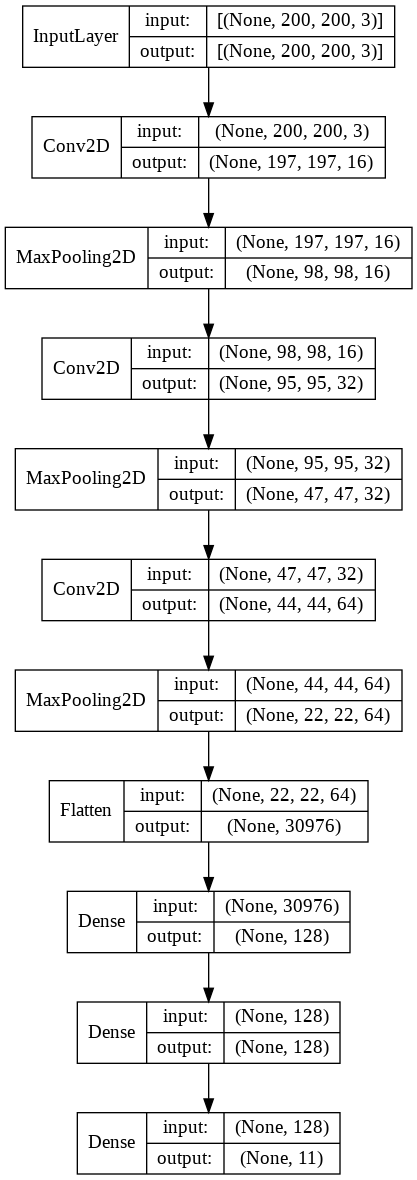

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.python.keras.utils.vis_utils import plot_model
from IPython.display import Image

nb_epoch = 40
batch_size = 128
nb_pool = 2 # larger pooling decreases image resolution too fast 

# Parameters for grid searches (among others)
nb_filters = 16
nb_conv = 4
dense_nodes = 128


# Manually trying some structures leads to something like this working quite well
# previously we performed GSs for structres like nb_filters = (64, 32, 16)
# but this new structure like (16, 32, 64) performs significantly better.
# Therefore, we discarded the old structure.

# non-unit stride (combined with bigger kernal size) did not improve accuracy

# 2 dense layers do improve the result, 3 do not help much compared to 2

# manually variing batch_size and learning_rate resulted in the settings used here

layers_base = [
    Conv2D(nb_filters, kernel_size=nb_conv, padding='valid', activation='relu', input_shape=shape_ord),
    MaxPooling2D(pool_size=nb_pool),
    Conv2D(nb_filters * 2, kernel_size=nb_conv, padding='valid', activation='relu'),
    MaxPooling2D(pool_size=nb_pool),
    Conv2D(nb_filters * 4, kernel_size=nb_conv, padding='valid', activation='relu'),
    MaxPooling2D(pool_size=nb_pool),
    Flatten(),
    Dense(dense_nodes, activation='relu'),
    Dense(dense_nodes, activation='relu'), # No dropout before the output layer -> too few weights
    Dense(len(flowers), activation='softmax')
]

model = Sequential(layers_base)
opt = tf.keras.optimizers.Adam(learning_rate=0.001) # this is the default setting for the adam optimizer
# learning_rate=0.01 does not work at all
# learning_rate=0.0001 is too slow considering our available resources (after 100 epochs val_accuracy still < 0.70)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
model.summary()

plot_model(model, to_file=path+"first_model.png", show_shapes=True, show_layer_names=False)
Image(path+"first_model.png")

In [21]:
# make folder to save loss curves in
if not os.path.isdir(path + "performance_plots"):
    os.mkdir(path + "performance_plots")

# Train the first network

In [16]:
hist = model.fit(
    x = X_train, y = y_train, 
    batch_size = batch_size, epochs = nb_epoch, 
    validation_data = (X_val, y_val),
    verbose = 1
)

Epoch 1/40
21/21 [==============================] - 35s 131ms/step - loss: 2.2684 - accuracy: 0.1914 - val_loss: 2.0259 - val_accuracy: 0.3140
Epoch 2/40
21/21 [==============================] - 2s 104ms/step - loss: 1.7104 - accuracy: 0.4135 - val_loss: 1.5865 - val_accuracy: 0.4483
Epoch 3/40
21/21 [==============================] - 2s 106ms/step - loss: 1.4586 - accuracy: 0.5119 - val_loss: 1.5034 - val_accuracy: 0.4846
Epoch 4/40
21/21 [==============================] - 2s 108ms/step - loss: 1.2721 - accuracy: 0.5753 - val_loss: 1.4227 - val_accuracy: 0.5263
Epoch 5/40
21/21 [==============================] - 2s 107ms/step - loss: 1.0084 - accuracy: 0.6647 - val_loss: 1.3565 - val_accuracy: 0.5445
Epoch 6/40
21/21 [==============================] - 2s 104ms/step - loss: 0.7184 - accuracy: 0.7658 - val_loss: 1.5573 - val_accuracy: 0.5789
Epoch 7/40
21/21 [==============================] - 2s 107ms/step - loss: 0.5325 - accuracy: 0.8320 - val_loss: 1.1738 - val_accuracy: 0.6661
Epoch

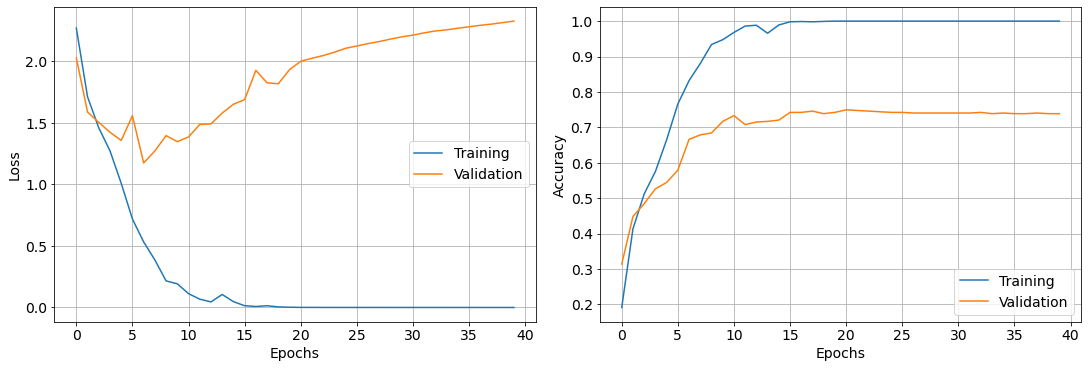

In [23]:
fig = plot_history(hist)
fig.savefig(path + "performance_plots/first_model.pdf")
fig.show()

# Squential Grid Searchs

In [24]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import InputLayer

## Grid Search 1 - $n_\mathrm{dense\,nodes}$

In [ ]:
def build_model_from_params(params):
    layers = [
        Conv2D(params["num_filters"][0], kernel_size=params["kernal_size"], padding='valid', activation='relu', input_shape=shape_ord),
        MaxPooling2D(pool_size=nb_pool),
        Conv2D(params["num_filters"][1], kernel_size=params["kernal_size"], padding='valid', activation='relu'),
        MaxPooling2D(pool_size=nb_pool),
        Conv2D(params["num_filters"][2], kernel_size=params["kernal_size"], padding='valid', activation='relu'),
        MaxPooling2D(pool_size=nb_pool),
        Flatten(),
        Dense(params["dense_nodes"], activation='relu'),
        Dense(params["dense_nodes"], activation='relu'),
        Dense(len(flowers), activation='softmax')
    ]

    model = Sequential(layers)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model 


param_space = {
    'num_filters': [[16, 32, 64]],
    'kernal_size': [4],
    'dense_nodes': [64, 96, 128, 160, 192, 224, 256]
}

value_combis = itertools.product(*[v for v in param_space.values()])

param_combis = [{key:value for key, value in zip(param_space.keys(), combi)} for combi in value_combis]

print(f"Es werden {len(param_combis)} Parameterkombination getestet.")

Es werden 7 Parameterkombination getestet.


In [ ]:
search_results = []

for idx, params in enumerate(param_combis):
    print(f"Starte Run {idx+1}/{len(param_combis)} mit den Parameteren: {params}")

    string_config = ""
    for key, value in params.items():
        string_config += "_" + key + "=" + str(value)

    # save best model according to validation accuracy
    filepath = path + f"GS1/paramsearch{string_config}.hdf5"
    checkpoint = ModelCheckpoint(
        filepath, monitor="val_accuracy", verbose=0, save_best_only=True, mode="max"
    )

    model = build_model_from_params(params)
    
    # train the model
    fit_results = model.fit(
        x = X_train, y = y_train, 
        batch_size = batch_size, epochs = nb_epoch, 
        validation_data = (X_val, y_val), 
        callbacks = [checkpoint],
        verbose = 0
    )

    # extract the best validation scores
    best_val_epoch    = np.argmax(fit_results.history['val_accuracy'])
    best_val_acc      = np.max(fit_results.history['val_accuracy'])
    best_val_acc_loss = fit_results.history['val_loss'][best_val_epoch]

    # get correct training accuracy
    best_val_acc_train_loss = fit_results.history['loss'][best_val_epoch]
    best_val_acc_train_acc =  fit_results.history['accuracy'][best_val_epoch]

    # store results
    search_results.append({
        **params,
        'best_val_acc': best_val_acc,
        'best_val_loss': best_val_acc_loss,
        'best_train_acc': best_val_acc_train_acc,
        'best_train_loss': best_val_acc_train_loss,
        'best_val_epoch': best_val_epoch,
        'history': fit_results.history
    })


resultsDF = pd.DataFrame(search_results)
resultsDF.to_hdf(path + "results_GS1.h5", key="results")

Starte Run 1/7 mit den Parameteren: {'num_filters': [16, 32, 64], 'kernal_size': 4, 'dense_nodes': 64}
Starte Run 2/7 mit den Parameteren: {'num_filters': [16, 32, 64], 'kernal_size': 4, 'dense_nodes': 96}
Starte Run 3/7 mit den Parameteren: {'num_filters': [16, 32, 64], 'kernal_size': 4, 'dense_nodes': 128}
Starte Run 4/7 mit den Parameteren: {'num_filters': [16, 32, 64], 'kernal_size': 4, 'dense_nodes': 160}
Starte Run 5/7 mit den Parameteren: {'num_filters': [16, 32, 64], 'kernal_size': 4, 'dense_nodes': 192}
Starte Run 6/7 mit den Parameteren: {'num_filters': [16, 32, 64], 'kernal_size': 4, 'dense_nodes': 224}
Starte Run 7/7 mit den Parameteren: {'num_filters': [16, 32, 64], 'kernal_size': 4, 'dense_nodes': 256}


/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:2449: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['num_filters', 'history'], dtype='object')]

  encoding=encoding,


In [25]:
#resultsDF = pd.read_hdf(path + "results_GS1.h5", key="results")
resultsDF.sort_values("best_val_acc", ascending=False, inplace=True)
resultsDF

,num_filters,kernal_size,dense_nodes,best_val_acc,best_val_loss,best_train_acc,best_train_loss,best_val_epoch,history
5,"[16, 32, 64]",4,224,0.769510,1.626345,1.000000,0.000399,22,"{'loss': [2.2359137535095215, 1.70825147628784..."
3,"[16, 32, 64]",4,160,0.764065,2.061808,1.000000,0.000101,39,"{'loss': [2.1883106231689453, 1.78234529495239..."
1,"[16, 32, 64]",4,96,0.756806,2.220190,1.000000,0.000157,37,"{'loss': [2.3186211585998535, 1.77382040023803..."
4,"[16, 32, 64]",4,192,0.756806,1.627217,0.996499,0.014385,11,"{'loss': [2.292104721069336, 1.794701933860778..."
2,"[16, 32, 64]",4,128,0.751361,1.534710,0.991443,0.037288,13,"{'loss': [2.282879590988159, 1.758570790290832..."
6,"[16, 32, 64]",4,256,0.749546,1.726527,0.999611,0.005129,15,"{'loss': [2.195491313934326, 1.684839844703674..."
0,"[16, 32, 64]",4,64,0.716878,1.373166,0.972384,0.101822,11,"{'loss': [2.380760908126831, 2.144404649734497..."


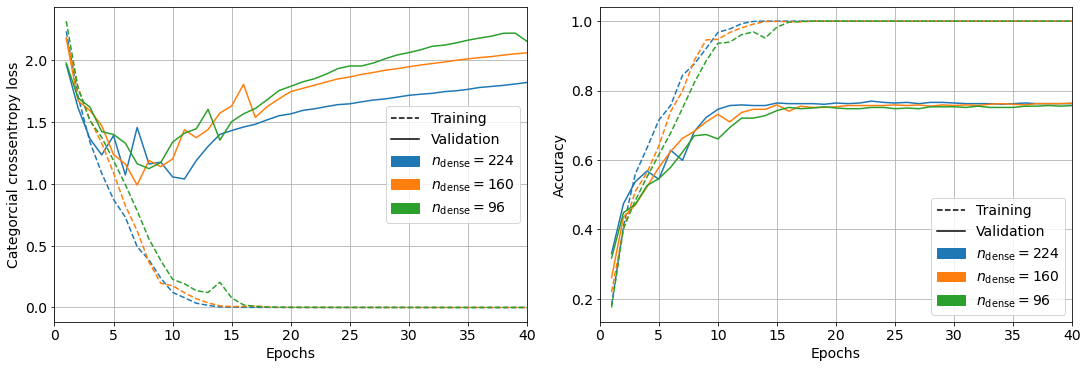

In [28]:
label_strings = []
N = 3
for row_idx, row_series in resultsDF.head(N).iterrows():
    label_strings.append(f"$n_\\mathrm{{dense}}=${row_series['dense_nodes']}")

fig = plot_topN_history_from_df(resultsDF, N, label_strings)
fig.savefig(path + "performance_plots/GS1.pdf")
fig.show()

Modell 5 (224 dense nodes) performs the best.

In [ ]:
best_model = load_model(path + "GS1/paramsearch_num_filters=[16, 32, 64]_kernal_size=4_dense_nodes=224.hdf5")
evaluate(best_model, X_val, y_val, 1)


## Grid Search 2 - $n_\mathrm{filters}$ + structure and $n_\mathrm{conv\,layers}$

In [ ]:
def build_model_from_params(params):
    model = Sequential()
    model.add(InputLayer(shape_ord))

    filters = params["num_filters"]
    # try: (24,24, 48,48, 96,96); (16,16, 32,32, 64,64); (8,8, 16,16, 32,32)
    if params["n_layers"] == 6:
        for i in range(3):
            model.add(Conv2D(
                filters, kernel_size=params["kernal_size"], padding='valid', activation='relu'
            ))
            model.add(Conv2D(
                filters, kernel_size=params["kernal_size"], padding='valid', activation='relu'
            ))
            model.add(MaxPooling2D(pool_size=nb_pool))
            filters *= 2
    # try: (24, 48, 96); (16, 32, 64); (8, 16, 32)
    # try: (24, 48, 96, 192); (16, 32, 64, 128); (8, 16, 32, 64) -> with 4 MaxPooling Layers!
    else:
        for i in range(params["n_layers"]):
            model.add(Conv2D(
                filters, kernel_size=params["kernal_size"], padding='valid', activation='relu'
            ))
            model.add(MaxPooling2D(pool_size=nb_pool))
            filters *= 2

    for layer in [Flatten(),
                  Dense(params["dense_nodes"], activation='relu'),
                  Dense(params["dense_nodes"], activation='relu'),
                  Dense(len(flowers), activation='softmax')]:
        model.add(layer)

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model 


param_space = {
    'num_filters': [8, 16, 24],
    'n_layers': [3, 4, 6],
    'kernal_size': [4],
    'dense_nodes': [224]
}

value_combis = itertools.product(*[v for v in param_space.values()])
param_combis = [{key:value for key, value in zip(param_space.keys(), combi)} for combi in value_combis]
print(f"Es werden {len(param_combis)} Parameterkombination getestet.")

Es werden 9 Parameterkombination getestet.


In [ ]:
search_results = []

for idx, params in enumerate(param_combis):
    print(f"Starte Run {idx+1}/{len(param_combis)} mit den Parameteren: {params}")

    string_config = ""
    for key, value in params.items():
        string_config += "_" + key + "=" + str(value)

    # save best model according to validation accuracy
    filepath = path + f"GS2/paramsearch{string_config}.hdf5"
    checkpoint = ModelCheckpoint(
        filepath, monitor="val_accuracy", verbose=0, save_best_only=True, mode="max"
    )

    model = build_model_from_params(params)
    
    # train the model
    fit_results = model.fit(
        x = X_train, y = y_train, 
        batch_size = batch_size, epochs = nb_epoch, 
        validation_data = (X_val, y_val), 
        callbacks = [checkpoint],
        verbose = 0
    )

    # extract the best validation scores
    best_val_epoch    = np.argmax(fit_results.history['val_accuracy'])
    best_val_acc      = np.max(fit_results.history['val_accuracy'])
    best_val_acc_loss = fit_results.history['val_loss'][best_val_epoch]

    # get correct training accuracy
    best_val_acc_train_loss = fit_results.history['loss'][best_val_epoch]
    best_val_acc_train_acc =  fit_results.history['accuracy'][best_val_epoch]

    # store results
    search_results.append({
        **params,
        'best_val_acc': best_val_acc,
        'best_val_loss': best_val_acc_loss,
        'best_train_acc': best_val_acc_train_acc,
        'best_train_loss': best_val_acc_train_loss,
        'best_val_epoch': best_val_epoch,
        'history': fit_results.history
    })


resultsDF = pd.DataFrame(search_results)
resultsDF.to_hdf(path + "results_GS2.h5", key="results")

Starte Run 1/9 mit den Parameteren: {'num_filters': 8, 'n_layers': 3, 'kernal_size': 4, 'dense_nodes': 224}
Starte Run 2/9 mit den Parameteren: {'num_filters': 8, 'n_layers': 4, 'kernal_size': 4, 'dense_nodes': 224}
Starte Run 3/9 mit den Parameteren: {'num_filters': 8, 'n_layers': 6, 'kernal_size': 4, 'dense_nodes': 224}
Starte Run 4/9 mit den Parameteren: {'num_filters': 16, 'n_layers': 3, 'kernal_size': 4, 'dense_nodes': 224}
Starte Run 5/9 mit den Parameteren: {'num_filters': 16, 'n_layers': 4, 'kernal_size': 4, 'dense_nodes': 224}
Starte Run 6/9 mit den Parameteren: {'num_filters': 16, 'n_layers': 6, 'kernal_size': 4, 'dense_nodes': 224}
Starte Run 7/9 mit den Parameteren: {'num_filters': 24, 'n_layers': 3, 'kernal_size': 4, 'dense_nodes': 224}
Starte Run 8/9 mit den Parameteren: {'num_filters': 24, 'n_layers': 4, 'kernal_size': 4, 'dense_nodes': 224}
Starte Run 9/9 mit den Parameteren: {'num_filters': 24, 'n_layers': 6, 'kernal_size': 4, 'dense_nodes': 224}


/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:2449: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['history'], dtype='object')]

  encoding=encoding,


In [29]:
#resultsDF = pd.read_hdf(path + "results_GS2.h5", key="results")
resultsDF.sort_values('best_val_acc', ascending=False, inplace=True)
resultsDF

,num_filters,n_layers,kernal_size,dense_nodes,best_val_acc,best_val_loss,best_train_acc,best_train_loss,best_val_epoch,history
7,24,4,4,224,0.785844,1.791788,1.000000,0.000555,24,"{'loss': [2.2987987995147705, 2.01679587364196..."
4,16,4,4,224,0.776770,1.795158,1.000000,0.004016,32,"{'loss': [2.266732692718506, 1.866156458854675..."
1,8,4,4,224,0.774955,1.749930,1.000000,0.003151,28,"{'loss': [2.236001968383789, 1.99258291721344,..."
6,24,3,4,224,0.751361,1.472227,0.993388,0.034457,11,"{'loss': [2.3640499114990234, 1.87200593948364..."
0,8,3,4,224,0.747731,1.448734,1.000000,0.002760,15,"{'loss': [2.2241525650024414, 1.74813175201416..."
3,16,3,4,224,0.747731,1.518845,1.000000,0.002299,14,"{'loss': [2.1405227184295654, 1.65316283702850..."
8,24,6,4,224,0.736842,2.644366,0.994944,0.018924,18,"{'loss': [2.293774366378784, 1.857466459274292..."
2,8,6,4,224,0.720508,2.271379,0.999611,0.004800,19,"{'loss': [2.276723623275757, 1.934771776199340..."
5,16,6,4,224,0.720508,2.834049,1.000000,0.000358,23,"{'loss': [2.2856814861297607, 2.01544690132141..."


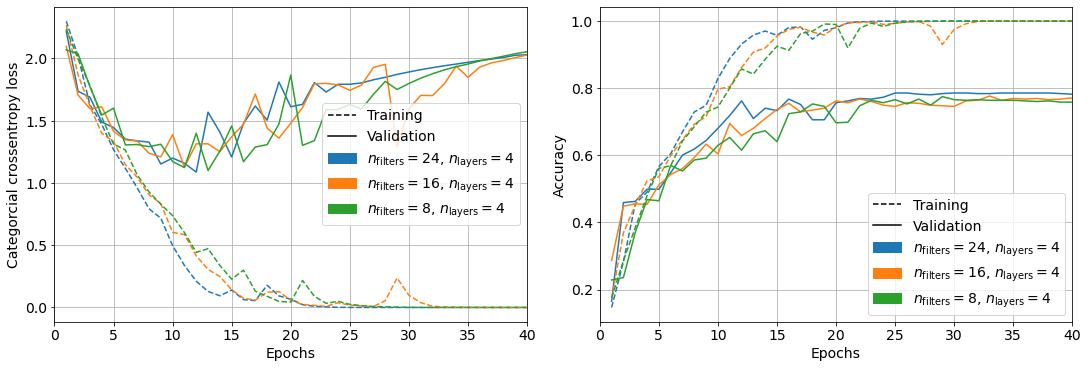

In [33]:
label_strings = []
N = 3
for row_idx, row_series in resultsDF.head(N).iterrows():
    label_strings.append(f"$n_\\mathrm{{filters}}=${row_series['num_filters']}, $n_\\mathrm{{layers}}=${row_series['n_layers']}")

fig = plot_topN_history_from_df(resultsDF, N, label_strings)
fig.savefig(path + "performance_plots/GS2.pdf")
fig.show()

- Modell 7 shows the best accuracy.
- 4 covolutional layer and 4 MaxPopling layer are to be preferred, but represent an upper limit of the searched parameter space!

In [ ]:
best_model = load_model(path + "GS2/paramsearch_num_filters=24_n_layers=4_kernal_size=4_dense_nodes=224.hdf5")
evaluate(best_model, X_val, y_val, 1)

### Extend parameter space
Try 5 covolutional layer + 5 MaxPooling layer (after 5 MaxPooling Layers the "image" resoultion is down to 3x3) and try even higher $n_\mathrm{filters}$.

In [ ]:
def build_model_from_params(params):
    model = Sequential()
    model.add(InputLayer(shape_ord))

    filters = params["num_filters"]
    for i in range(params["n_layers"]):
        model.add(Conv2D(
            filters, kernel_size=params["kernal_size"], padding='valid', activation='relu'
        ))
        model.add(MaxPooling2D(pool_size=nb_pool))
        filters *= 2

    for layer in [Flatten(),
                  Dense(params["dense_nodes"], activation='relu'),
                  Dense(params["dense_nodes"], activation='relu'),
                  Dense(len(flowers), activation='softmax')]:
        model.add(layer)

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model 


param_space = {
    'num_filters': [16, 24, 32, 40, 48],
    'n_layers': [4, 5],
    'kernal_size': [4],
    'dense_nodes': [224]
}

value_combis = itertools.product(*[v for v in param_space.values()])
param_combis = [{key:value for key, value in zip(param_space.keys(), combi)} for combi in value_combis]
print(f"Es werden {len(param_combis)} Parameterkombination getestet.")

Es werden 10 Parameterkombination getestet.


In [ ]:
search_results = []

for idx, params in enumerate(param_combis):
    print(f"Starte Run {idx+1}/{len(param_combis)} mit den Parameteren: {params}")

    string_config = ""
    for key, value in params.items():
        string_config += "_" + key + "=" + str(value)

    # save best model according to validation accuracy
    filepath = path + f"GS2/paramsearch{string_config}.hdf5"
    checkpoint = ModelCheckpoint(
        filepath, monitor="val_accuracy", verbose=0, save_best_only=True, mode="max"
    )

    model = build_model_from_params(params)
    
    # train the model
    fit_results = model.fit(
        x = X_train, y = y_train, 
        batch_size = batch_size, epochs = nb_epoch, 
        validation_data = (X_val, y_val), 
        callbacks = [checkpoint],
        verbose = 0
    )

    # extract the best validation scores
    best_val_epoch    = np.argmax(fit_results.history['val_accuracy'])
    best_val_acc      = np.max(fit_results.history['val_accuracy'])
    best_val_acc_loss = fit_results.history['val_loss'][best_val_epoch]

    # get correct training accuracy
    best_val_acc_train_loss = fit_results.history['loss'][best_val_epoch]
    best_val_acc_train_acc =  fit_results.history['accuracy'][best_val_epoch]

    # store results
    search_results.append({
        **params,
        'best_val_acc': best_val_acc,
        'best_val_loss': best_val_acc_loss,
        'best_train_acc': best_val_acc_train_acc,
        'best_train_loss': best_val_acc_train_loss,
        'best_val_epoch': best_val_epoch,
        'history': fit_results.history
    })


resultsDF = pd.DataFrame(search_results)
resultsDF.to_hdf(path + "results_GS2_ext.h5", key="results")

Starte Run 1/10 mit den Parameteren: {'num_filters': 16, 'n_layers': 4, 'kernal_size': 4, 'dense_nodes': 224}
Starte Run 2/10 mit den Parameteren: {'num_filters': 16, 'n_layers': 5, 'kernal_size': 4, 'dense_nodes': 224}
Starte Run 3/10 mit den Parameteren: {'num_filters': 24, 'n_layers': 4, 'kernal_size': 4, 'dense_nodes': 224}
Starte Run 4/10 mit den Parameteren: {'num_filters': 24, 'n_layers': 5, 'kernal_size': 4, 'dense_nodes': 224}
Starte Run 5/10 mit den Parameteren: {'num_filters': 32, 'n_layers': 4, 'kernal_size': 4, 'dense_nodes': 224}
Starte Run 6/10 mit den Parameteren: {'num_filters': 32, 'n_layers': 5, 'kernal_size': 4, 'dense_nodes': 224}
Starte Run 7/10 mit den Parameteren: {'num_filters': 40, 'n_layers': 4, 'kernal_size': 4, 'dense_nodes': 224}
Starte Run 8/10 mit den Parameteren: {'num_filters': 40, 'n_layers': 5, 'kernal_size': 4, 'dense_nodes': 224}
Starte Run 9/10 mit den Parameteren: {'num_filters': 48, 'n_layers': 4, 'kernal_size': 4, 'dense_nodes': 224}
Starte Run

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:2449: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['history'], dtype='object')]

  encoding=encoding,


In [34]:
#resultsDF = pd.read_hdf(path + "results_GS2_ext.h5", key="results")
resultsDF.sort_values('best_val_acc', ascending=False, inplace=True)
resultsDF

,num_filters,n_layers,kernal_size,dense_nodes,best_val_acc,best_val_loss,best_train_acc,best_train_loss,best_val_epoch,history
9,48,5,4,224,0.820327,1.373922,0.987165,0.046629,26,"{'loss': [2.3266189098358154, 2.06800770759582..."
5,32,5,4,224,0.813067,1.296027,0.993777,0.020911,37,"{'loss': [2.3735835552215576, 2.15022206306457..."
7,40,5,4,224,0.807622,1.520102,0.999222,0.004653,33,"{'loss': [2.3468360900878906, 2.18545460700988..."
3,24,5,4,224,0.805808,1.424050,1.000000,0.001696,39,"{'loss': [2.3303327560424805, 1.98868501186370..."
1,16,5,4,224,0.787659,1.743629,0.998833,0.005790,34,"{'loss': [2.217210292816162, 1.886963963508606..."
4,32,4,4,224,0.785844,1.994562,0.999611,0.001722,27,"{'loss': [2.297483205795288, 1.847203254699707..."
6,40,4,4,224,0.782214,1.963249,0.998444,0.007611,23,"{'loss': [2.276827812194824, 1.847079038619995..."
2,24,4,4,224,0.774955,1.408885,0.994555,0.024899,16,"{'loss': [2.0513839721679688, 1.60159587860107..."
0,16,4,4,224,0.771325,1.970100,1.000000,0.000546,27,"{'loss': [2.307380437850952, 2.039633274078369..."
8,48,4,4,224,0.767695,1.566893,0.982886,0.056681,20,"{'loss': [2.3728349208831787, 1.93439829349517..."


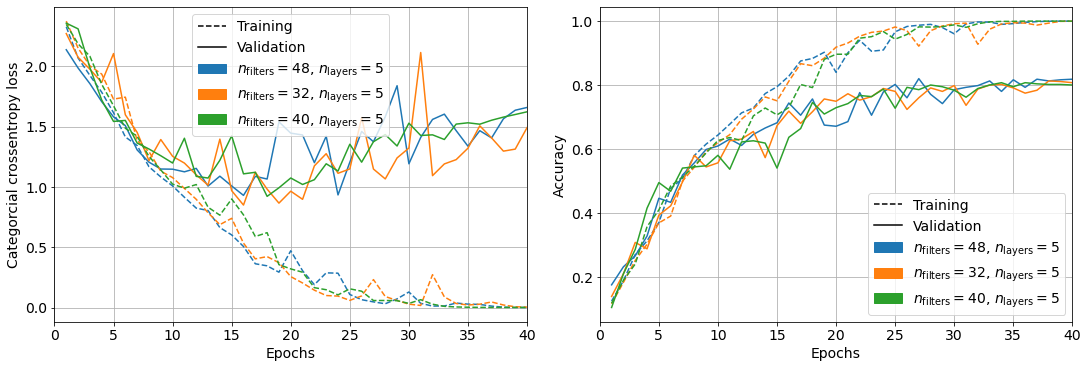

In [36]:
label_strings = []
N = 3
for row_idx, row_series in resultsDF.head(N).iterrows():
    label_strings.append(f"$n_\\mathrm{{filters}}=${row_series['num_filters']}, $n_\\mathrm{{layers}}=${row_series['n_layers']}")

fig = plot_topN_history_from_df(resultsDF, N, label_strings)
fig.savefig(path + "performance_plots/GS2_ext.pdf")
fig.show()

### Extend parameter space further
5 convolutional layers perform even better than 4 and even larger $n_\mathrm{filters}$ might improve accuracy further

In [ ]:
nb_epoch = 80 # longer training seems necessary for larger num_filters

def build_model_from_params(params):
    layers = [
        Conv2D(params["num_filters"], kernel_size=params["kernal_size"], padding='valid', activation='relu', input_shape=shape_ord),
        MaxPooling2D(pool_size=nb_pool),
        Conv2D(params["num_filters"] * 2, kernel_size=params["kernal_size"], padding='valid', activation='relu'),
        MaxPooling2D(pool_size=nb_pool),
        Conv2D(params["num_filters"] * 4, kernel_size=params["kernal_size"], padding='valid', activation='relu'),
        MaxPooling2D(pool_size=nb_pool),
        Conv2D(params["num_filters"] * 8, kernel_size=params["kernal_size"], padding='valid', activation='relu'),
        MaxPooling2D(pool_size=nb_pool),
        Conv2D(params["num_filters"] * 16, kernel_size=params["kernal_size"], padding='valid', activation='relu'),
        MaxPooling2D(pool_size=nb_pool),
        Flatten(),
        Dense(params["dense_nodes"], activation='relu'),
        Dense(params["dense_nodes"], activation='relu'),
        Dense(len(flowers), activation='softmax')
    ]

    model = Sequential(layers)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model 


param_space = {
    'num_filters': [48, 64, 80, 96],
    'kernal_size': [4],
    'dense_nodes': [224]
}

value_combis = itertools.product(*[v for v in param_space.values()])
param_combis = [{key:value for key, value in zip(param_space.keys(), combi)} for combi in value_combis]
print(f"Es werden {len(param_combis)} Parameterkombination getestet.")

Es werden 4 Parameterkombination getestet.


In [ ]:
search_results = []

for idx, params in enumerate(param_combis):
    print(f"Starte Run {idx+1}/{len(param_combis)} mit den Parameteren: {params}")

    string_config = ""
    for key, value in params.items():
        string_config += "_" + key + "=" + str(value)

    # save best model according to validation accuracy
    filepath = path + f"GS2/paramsearch{string_config}.hdf5"
    checkpoint = ModelCheckpoint(
        filepath, monitor="val_accuracy", verbose=0, save_best_only=True, mode="max"
    )

    model = build_model_from_params(params)
    
    # train the model
    fit_results = model.fit(
        x = X_train, y = y_train, 
        batch_size = batch_size, epochs = nb_epoch, 
        validation_data = (X_val, y_val), 
        callbacks = [checkpoint],
        verbose = 0
    )

    # extract the best validation scores
    best_val_epoch    = np.argmax(fit_results.history['val_accuracy'])
    best_val_acc      = np.max(fit_results.history['val_accuracy'])
    best_val_acc_loss = fit_results.history['val_loss'][best_val_epoch]

    # get correct training accuracy
    best_val_acc_train_loss = fit_results.history['loss'][best_val_epoch]
    best_val_acc_train_acc =  fit_results.history['accuracy'][best_val_epoch]

    # store results
    search_results.append({
        **params,
        'best_val_acc': best_val_acc,
        'best_val_loss': best_val_acc_loss,
        'best_train_acc': best_val_acc_train_acc,
        'best_train_loss': best_val_acc_train_loss,
        'best_val_epoch': best_val_epoch,
        'history': fit_results.history
    })


resultsDF = pd.DataFrame(search_results)
resultsDF.to_hdf(path + "results_GS2_ext2.h5", key="results")

Starte Run 1/4 mit den Parameteren: {'num_filters': 48, 'kernal_size': 4, 'dense_nodes': 224}
Starte Run 2/4 mit den Parameteren: {'num_filters': 64, 'kernal_size': 4, 'dense_nodes': 224}
Starte Run 3/4 mit den Parameteren: {'num_filters': 80, 'kernal_size': 4, 'dense_nodes': 224}
Starte Run 4/4 mit den Parameteren: {'num_filters': 96, 'kernal_size': 4, 'dense_nodes': 224}


/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:2449: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['history'], dtype='object')]

  encoding=encoding,


In [37]:
#resultsDF = pd.read_hdf(path + "results_GS2_ext2.h5", key="results")
resultsDF.sort_values('best_val_acc', ascending=False, inplace=True)
resultsDF

,num_filters,kernal_size,dense_nodes,best_val_acc,best_val_loss,best_train_acc,best_train_loss,best_val_epoch,history
3,96,4,224,0.829401,1.958732,1.000000,0.000073,55,"{'loss': [2.7551932334899902, 2.36255359649658..."
0,48,4,224,0.813067,1.540181,0.992999,0.021968,32,"{'loss': [2.2842090129852295, 1.97087001800537..."
1,64,4,224,0.805808,1.557427,0.991832,0.037687,32,"{'loss': [2.3607256412506104, 2.06261444091796..."
2,80,4,224,0.778584,2.693943,1.000000,0.000047,62,"{'loss': [2.448957920074463, 2.185364007949829..."


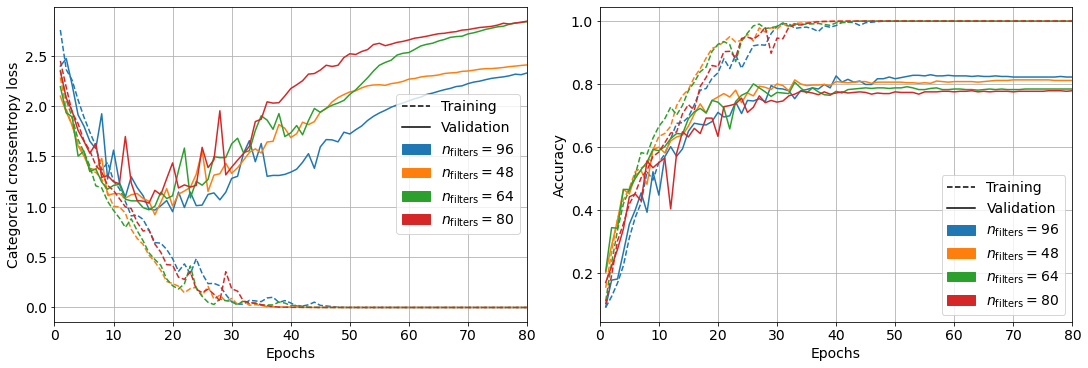

In [39]:
label_strings = []
N = 4
for row_idx, row_series in resultsDF.head(N).iterrows():
    label_strings.append(f"$n_\\mathrm{{filters}}=${row_series['num_filters']}")

fig = plot_topN_history_from_df(resultsDF, N, label_strings)
fig.savefig(path + "performance_plots/GS2_ext2.pdf")
fig.show()

$n_\mathrm{filters} = 96$ is performing the best. But in regards to the computing resources available to us and because $n_\mathrm{filters} = 48$ is performing second best, we choose $n_\mathrm{filters} = 48$ as the optimal number of filters for our Problem (Occam's Razor). 

## Grid Search 3 - Kernel size

In [ ]:
nb_epoch = 60 # should be enough for num_filters = 48 

def build_model_from_params(params):
    layers = [
        Conv2D(params["num_filters"], kernel_size=params["kernal_size"], padding='valid', activation='relu', input_shape=shape_ord),
        MaxPooling2D(pool_size=nb_pool),
        Conv2D(params["num_filters"] * 2, kernel_size=params["kernal_size"], padding='valid', activation='relu'),
        MaxPooling2D(pool_size=nb_pool),
        Conv2D(params["num_filters"] * 4, kernel_size=params["kernal_size"], padding='valid', activation='relu'),
        MaxPooling2D(pool_size=nb_pool),
        Conv2D(params["num_filters"] * 8, kernel_size=params["kernal_size"], padding='valid', activation='relu'),
        MaxPooling2D(pool_size=nb_pool),
        Conv2D(params["num_filters"] * 16, kernel_size=params["kernal_size"], padding='valid', activation='relu'),
        MaxPooling2D(pool_size=nb_pool),
        Flatten(),
        Dense(params["dense_nodes"], activation='relu'),
        Dense(params["dense_nodes"], activation='relu'),
        Dense(len(flowers), activation='softmax')
    ]

    model = Sequential(layers)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model 


param_space = {
    'num_filters': [48],
    'kernal_size': [2, 3, 4, 5, 6], # all possible kernal sizes for our structure
    'dense_nodes': [224]
}

value_combis = itertools.product(*[v for v in param_space.values()])
param_combis = [{key:value for key, value in zip(param_space.keys(), combi)} for combi in value_combis]
print(f"Es werden {len(param_combis)} Parameterkombination getestet.")

Es werden 5 Parameterkombination getestet.


In [ ]:
search_results = []

for idx, params in enumerate(param_combis):
    print(f"Starte Run {idx+1}/{len(param_combis)} mit den Parameteren: {params}")

    string_config = ""
    for key, value in params.items():
        string_config += "_" + key + "=" + str(value)

    # save best model according to validation accuracy
    filepath = path + f"GS3/paramsearch{string_config}.hdf5"
    checkpoint = ModelCheckpoint(
        filepath, monitor="val_accuracy", verbose=0, save_best_only=True, mode="max"
    )

    model = build_model_from_params(params)
    
    # train the model
    fit_results = model.fit(
        x = X_train, y = y_train, 
        batch_size = batch_size, epochs = nb_epoch, 
        validation_data = (X_val, y_val), 
        callbacks = [checkpoint],
        verbose = 0
    )

    # extract the best validation scores
    best_val_epoch    = np.argmax(fit_results.history['val_accuracy'])
    best_val_acc      = np.max(fit_results.history['val_accuracy'])
    best_val_acc_loss = fit_results.history['val_loss'][best_val_epoch]

    # get correct training accuracy
    best_val_acc_train_loss = fit_results.history['loss'][best_val_epoch]
    best_val_acc_train_acc =  fit_results.history['accuracy'][best_val_epoch]

    # store results
    search_results.append({
        **params,
        'best_val_acc': best_val_acc,
        'best_val_loss': best_val_acc_loss,
        'best_train_acc': best_val_acc_train_acc,
        'best_train_loss': best_val_acc_train_loss,
        'best_val_epoch': best_val_epoch,
        'history': fit_results.history
    })


resultsDF = pd.DataFrame(search_results)
resultsDF.to_hdf(path + "results_GS3.h5", key="results")

Starte Run 1/5 mit den Parameteren: {'num_filters': 48, 'kernal_size': 2, 'dense_nodes': 224}
Starte Run 2/5 mit den Parameteren: {'num_filters': 48, 'kernal_size': 3, 'dense_nodes': 224}
Starte Run 3/5 mit den Parameteren: {'num_filters': 48, 'kernal_size': 4, 'dense_nodes': 224}
Starte Run 4/5 mit den Parameteren: {'num_filters': 48, 'kernal_size': 5, 'dense_nodes': 224}
Starte Run 5/5 mit den Parameteren: {'num_filters': 48, 'kernal_size': 6, 'dense_nodes': 224}


/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:2449: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['history'], dtype='object')]

  encoding=encoding,


In [40]:
#resultsDF = pd.read_hdf(path + "results_GS3.h5", key="results")
resultsDF.sort_values('best_val_acc', ascending=False, inplace=True)
resultsDF

,num_filters,kernal_size,dense_nodes,best_val_acc,best_val_loss,best_train_acc,best_train_loss,best_val_epoch,history
2,48,4,224,0.820327,1.188641,0.993388,0.031232,34,"{'loss': [2.290285110473633, 2.131956577301025..."
3,48,5,224,0.814882,1.451924,0.998444,0.007415,37,"{'loss': [2.4120819568634033, 2.08311986923217..."
1,48,3,224,0.805808,1.755356,0.998055,0.007058,29,"{'loss': [2.2519798278808594, 1.81640136241912..."
0,48,2,224,0.791289,1.263089,0.981330,0.062773,19,"{'loss': [2.245253086090088, 2.020770072937011..."
4,48,6,224,0.784029,1.774128,0.974718,0.087760,30,"{'loss': [2.338944673538208, 2.023434162139892..."


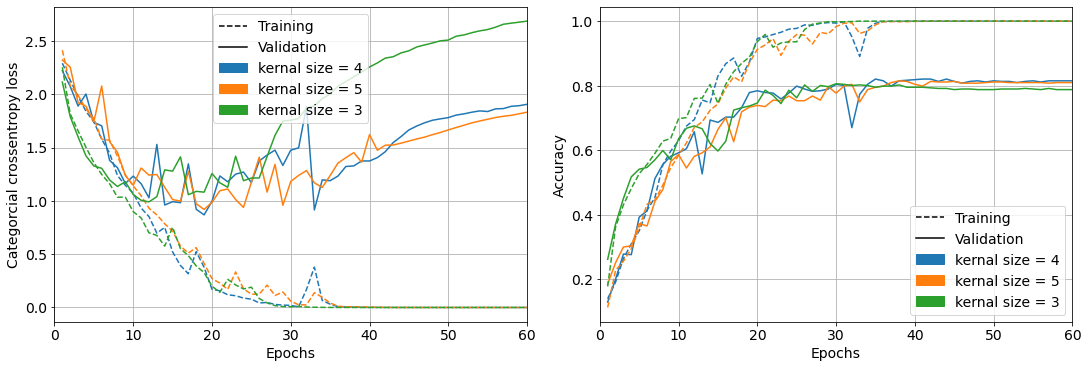

In [42]:
label_strings = []
N = 3
for row_idx, row_series in resultsDF.head(N).iterrows():
    label_strings.append(f"kernal size = {row_series['kernal_size']}")

fig = plot_topN_history_from_df(resultsDF, N, label_strings)
fig.savefig(path + "performance_plots/GS3.pdf")
fig.show()

Kernal size = 4 performs the best, therefore we will keep it.

In [ ]:
best_model = load_model(path + "GS3/paramsearch_num_filters=48_kernal_size=4_dense_nodes=224.hdf5")
evaluate(best_model, X_val, y_val, 1)

## Grid Search 4 - $n_\mathrm{dense\,nodes}$ and number of dense layers again
- The changed structure of the convolutional part of the NN (compared to Grid Search 1) motivates a second Search for the optimal dense structure.

In [ ]:
nb_epoch = 60 # should be enough for num_filters = 48 

def build_model_from_params(params):
    layers = [
        Conv2D(params["num_filters"], kernel_size=params["kernal_size"], padding='valid', activation='relu', input_shape=shape_ord),
        MaxPooling2D(pool_size=nb_pool),
        Conv2D(params["num_filters"] * 2, kernel_size=params["kernal_size"], padding='valid', activation='relu'),
        MaxPooling2D(pool_size=nb_pool),
        Conv2D(params["num_filters"] * 4, kernel_size=params["kernal_size"], padding='valid', activation='relu'),
        MaxPooling2D(pool_size=nb_pool),
        Conv2D(params["num_filters"] * 8, kernel_size=params["kernal_size"], padding='valid', activation='relu'),
        MaxPooling2D(pool_size=nb_pool),
        Conv2D(params["num_filters"] * 16, kernel_size=params["kernal_size"], padding='valid', activation='relu'),
        MaxPooling2D(pool_size=nb_pool),
        Flatten(),
    ]
    model = Sequential(layers)

    for nodes in params["dense_nodes"]:
        model.add(Dense(nodes, activation='relu'))

    model.add(Dense(len(flowers), activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model 


# Try one and two dense layers and different widths
param_space = {
    'num_filters': [48],
    'kernal_size': [4],
    'dense_nodes': [[64, 64], [128, 128], [192, 192], [256, 256], [128], [192], [256]]
}

value_combis = itertools.product(*[v for v in param_space.values()])
param_combis = [{key:value for key, value in zip(param_space.keys(), combi)} for combi in value_combis]
print(f"Es werden {len(param_combis)} Parameterkombination getestet.")

Es werden 7 Parameterkombination getestet.


In [ ]:
search_results = []

for idx, params in enumerate(param_combis):
    print(f"Starte Run {idx+1}/{len(param_combis)} mit den Parameteren: {params}")

    string_config = ""
    for key, value in params.items():
        string_config += "_" + key + "=" + str(value)

    # save best model according to validation accuracy
    filepath = path + f"GS4/paramsearch{string_config}.hdf5"
    checkpoint = ModelCheckpoint(
        filepath, monitor="val_accuracy", verbose=0, save_best_only=True, mode="max"
    )

    model = build_model_from_params(params)
    
    # train the model
    fit_results = model.fit(
        x = X_train, y = y_train, 
        batch_size = batch_size, epochs = nb_epoch, 
        validation_data = (X_val, y_val), 
        callbacks = [checkpoint],
        verbose = 0
    )

    # extract the best validation scores
    best_val_epoch    = np.argmax(fit_results.history['val_accuracy'])
    best_val_acc      = np.max(fit_results.history['val_accuracy'])
    best_val_acc_loss = fit_results.history['val_loss'][best_val_epoch]

    # get correct training accuracy
    best_val_acc_train_loss = fit_results.history['loss'][best_val_epoch]
    best_val_acc_train_acc =  fit_results.history['accuracy'][best_val_epoch]

    # store results
    search_results.append({
        **params,
        'best_val_acc': best_val_acc,
        'best_val_loss': best_val_acc_loss,
        'best_train_acc': best_val_acc_train_acc,
        'best_train_loss': best_val_acc_train_loss,
        'best_val_epoch': best_val_epoch,
        'history': fit_results.history
    })


resultsDF = pd.DataFrame(search_results)
resultsDF.to_hdf(path + "results_GS4.h5", key="results")

Starte Run 1/7 mit den Parameteren: {'num_filters': 48, 'kernal_size': 4, 'dense_nodes': [64, 64]}
Starte Run 2/7 mit den Parameteren: {'num_filters': 48, 'kernal_size': 4, 'dense_nodes': [128, 128]}
Starte Run 3/7 mit den Parameteren: {'num_filters': 48, 'kernal_size': 4, 'dense_nodes': [192, 192]}
Starte Run 4/7 mit den Parameteren: {'num_filters': 48, 'kernal_size': 4, 'dense_nodes': [256, 256]}
Starte Run 5/7 mit den Parameteren: {'num_filters': 48, 'kernal_size': 4, 'dense_nodes': [128]}
Starte Run 6/7 mit den Parameteren: {'num_filters': 48, 'kernal_size': 4, 'dense_nodes': [192]}
Starte Run 7/7 mit den Parameteren: {'num_filters': 48, 'kernal_size': 4, 'dense_nodes': [256]}


/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:2449: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['dense_nodes', 'history'], dtype='object')]

  encoding=encoding,


In [43]:
#resultsDF = pd.read_hdf(path + "results_GS4.h5", key="results")
resultsDF.sort_values('best_val_acc', ascending=False, inplace=True)
resultsDF

,num_filters,kernal_size,dense_nodes,best_val_acc,best_val_loss,best_train_acc,best_train_loss,best_val_epoch,history
4,48,4,[128],0.823956,1.475833,0.998833,0.006005,44,"{'loss': [2.3774774074554443, 2.21192240715026..."
1,48,4,"[128, 128]",0.820327,2.170260,1.000000,0.000027,57,"{'loss': [2.362201452255249, 2.159041881561279..."
3,48,4,"[256, 256]",0.820327,1.424730,0.998055,0.009461,32,"{'loss': [2.304572105407715, 2.094391584396362..."
2,48,4,"[192, 192]",0.816697,1.688398,0.999611,0.001627,34,"{'loss': [2.3513448238372803, 2.13060450553894..."
0,48,4,"[64, 64]",0.814882,1.947961,0.999611,0.000866,38,"{'loss': [2.3516862392425537, 2.15084147453308..."
5,48,4,[192],0.805808,0.965147,0.956826,0.144000,29,"{'loss': [2.4159679412841797, 2.17071127891540..."
6,48,4,[256],0.802178,1.443772,0.989887,0.032314,29,"{'loss': [2.321826457977295, 2.065215826034546..."


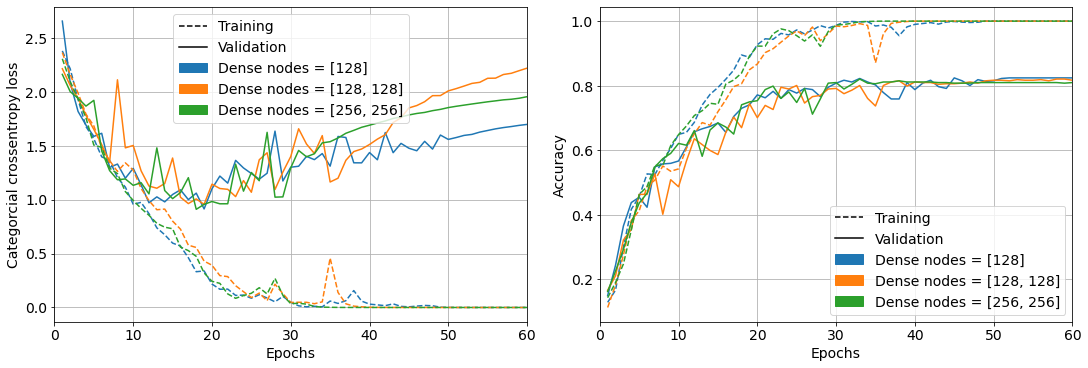

In [47]:
label_strings = []
N = 3
for row_idx, row_series in resultsDF.head(N).iterrows():
    label_strings.append(f"Dense nodes = {row_series['dense_nodes']}")

fig = plot_topN_history_from_df(resultsDF, N, label_strings)
fig.savefig(path + "performance_plots/GS4.pdf")
fig.show()

Looking at the accuracy curve, it seems as one layer with 128 nodes converges on the best accuracy in later training epochs, as well as having the overall best accuracy in a single epoch at any point. Therefore, we choose it as the new best dense structure for our problem.

In [ ]:
#!ls $path/GS4

best_model = load_model(path + "GS4/paramsearch_num_filters=48_kernal_size=4_dense_nodes=[128].hdf5")
best_model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_48 (Conv2D)           (None, 197, 197, 48)      2352      
_________________________________________________________________
max_pooling2d_48 (MaxPooling (None, 98, 98, 48)        0         
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 95, 95, 96)        73824     
_________________________________________________________________
max_pooling2d_49 (MaxPooling (None, 47, 47, 96)        0         
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 44, 44, 192)       295104    
_________________________________________________________________
max_pooling2d_50 (MaxPooling (None, 22, 22, 192)       0         
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 19, 19, 384)     

## First conclusion on optimal hyperparameters
- batch size = 128
- learning rate = 0.001 (default)
- 1 hidden dense layer 
- 128 nodes in the hidden layer
- 5 convolutioal layers with MaxPooling after each layer
- (48, 96, 192, 384, 768) filters for convolutional layers
- 4 x 4 kernals

# Regularization

In [ ]:
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2

class HistoryEpoch(Callback):
    def __init__(self, data):
        self.data = data       

    def on_epoch_end(self, epoch, logs={}):
        x, y = self.data
        l, a = self.model.evaluate(x, y, verbose=0)
        logs['loss'] = l
        logs['accuracy'] = a

def build_model_from_params(params):
    layers = [
        Conv2D(params["num_filters"], kernel_size=params["kernal_size"], 
               padding='valid', activation='relu', kernel_regularizer=l2(params['l2_rate']), input_shape=shape_ord),
        MaxPooling2D(pool_size=nb_pool),
        Conv2D(params["num_filters"] * 2, kernel_size=params["kernal_size"], 
               padding='valid', activation='relu', kernel_regularizer=l2(params['l2_rate'])),
        MaxPooling2D(pool_size=nb_pool),
        Conv2D(params["num_filters"] * 4, kernel_size=params["kernal_size"], 
               padding='valid', activation='relu', kernel_regularizer=l2(params['l2_rate'])),
        MaxPooling2D(pool_size=nb_pool),
        Conv2D(params["num_filters"] * 8, kernel_size=params["kernal_size"], 
               padding='valid', activation='relu', kernel_regularizer=l2(params['l2_rate'])),
        MaxPooling2D(pool_size=nb_pool),
        Conv2D(params["num_filters"] * 16, kernel_size=params["kernal_size"], 
               padding='valid', activation='relu', kernel_regularizer=l2(params['l2_rate'])),
        MaxPooling2D(pool_size=nb_pool),
        Flatten(),
        Dropout(params["dropout"]),
        Dense(params["dense_nodes"], activation='relu', kernel_regularizer=l2(params['l2_rate'])),
        Dense(len(flowers), activation='softmax')
    ]

    model = Sequential(layers)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model 

## Try Dropout

In [ ]:
nb_epoch = 80 # High dropout rates need longer training

param_space = {
    'num_filters': [48],
    'kernal_size': [4],
    'dense_nodes': [128],
    'dropout': [0.0, 0.1, 0.2, 0.3, 0.4],
    'l2_rate': [0.0]
}

value_combis = itertools.product(*[v for v in param_space.values()])
param_combis = [{key:value for key, value in zip(param_space.keys(), combi)} for combi in value_combis]
print(f"Es werden {len(param_combis)} Parameterkombination getestet.")

Es werden 5 Parameterkombination getestet.


In [ ]:
search_results = []

for idx, params in enumerate(param_combis):
    print(f"Starte Run {idx+1}/{len(param_combis)} mit den Parameteren: {params}")

    string_config = ""
    for key, value in params.items():
        string_config += "_" + key + "=" + str(value)

    # save best model according to validation accuracy
    filepath = path + f"Regularization/paramsearch{string_config}.hdf5"
    checkpoint = ModelCheckpoint(
        filepath, monitor="val_accuracy", verbose=0, save_best_only=True, mode="max"
    )

    model = build_model_from_params(params)
    
    # train the model
    fit_results = model.fit(
        x = X_train, y = y_train, 
        batch_size = batch_size, epochs = nb_epoch, 
        validation_data = (X_val, y_val), 
        callbacks = [checkpoint, HistoryEpoch((X_train, y_train))],
        verbose = 0
    )

    # extract the best validation scores
    best_val_epoch    = np.argmax(fit_results.history['val_accuracy'])
    best_val_acc      = np.max(fit_results.history['val_accuracy'])
    best_val_acc_loss = fit_results.history['val_loss'][best_val_epoch]

    # get correct training accuracy
    best_val_acc_train_loss = fit_results.history['loss'][best_val_epoch]
    best_val_acc_train_acc =  fit_results.history['accuracy'][best_val_epoch]

    # store results
    search_results.append({
        **params,
        'best_val_acc': best_val_acc,
        'best_val_loss': best_val_acc_loss,
        'best_train_acc': best_val_acc_train_acc,
        'best_train_loss': best_val_acc_train_loss,
        'best_val_epoch': best_val_epoch,
        'history': fit_results.history
    })


resultsDF = pd.DataFrame(search_results)
resultsDF.to_hdf(path + "results_regularization_dropout.h5", key="results")

Starte Run 1/5 mit den Parameteren: {'num_filters': 48, 'kernal_size': 4, 'dense_nodes': 128, 'dropout': 0.0, 'l2_rate': 0.0}
Starte Run 2/5 mit den Parameteren: {'num_filters': 48, 'kernal_size': 4, 'dense_nodes': 128, 'dropout': 0.1, 'l2_rate': 0.0}
Starte Run 3/5 mit den Parameteren: {'num_filters': 48, 'kernal_size': 4, 'dense_nodes': 128, 'dropout': 0.2, 'l2_rate': 0.0}
Starte Run 4/5 mit den Parameteren: {'num_filters': 48, 'kernal_size': 4, 'dense_nodes': 128, 'dropout': 0.3, 'l2_rate': 0.0}
Starte Run 5/5 mit den Parameteren: {'num_filters': 48, 'kernal_size': 4, 'dense_nodes': 128, 'dropout': 0.4, 'l2_rate': 0.0}


/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:2449: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['history'], dtype='object')]

  encoding=encoding,


In [48]:
#resultsDF = pd.read_hdf(path + "results_regularization_dropout.h5", key="results")
resultsDF.sort_values('best_val_acc', ascending=False, inplace=True)
resultsDF

,num_filters,kernal_size,dense_nodes,dropout,l2_rate,best_val_acc,best_val_loss,best_train_acc,best_train_loss,best_val_epoch,history
4,48,4,128,0.4,0.0,0.823956,1.494347,1.000000,0.000550,55,"{'loss': [2.1364381313323975, 1.78512799739837..."
2,48,4,128,0.2,0.0,0.820327,1.778094,0.999222,0.001945,72,"{'loss': [2.1654741764068604, 1.95158493518829..."
1,48,4,128,0.1,0.0,0.816697,1.512342,1.000000,0.001138,36,"{'loss': [2.294036626815796, 2.125942468643188..."
3,48,4,128,0.3,0.0,0.814882,1.639435,0.998833,0.002102,71,"{'loss': [2.138169288635254, 2.073633909225464..."
0,48,4,128,0.0,0.0,0.803993,1.787358,1.000000,0.000107,48,"{'loss': [2.1671671867370605, 2.11077260971069..."


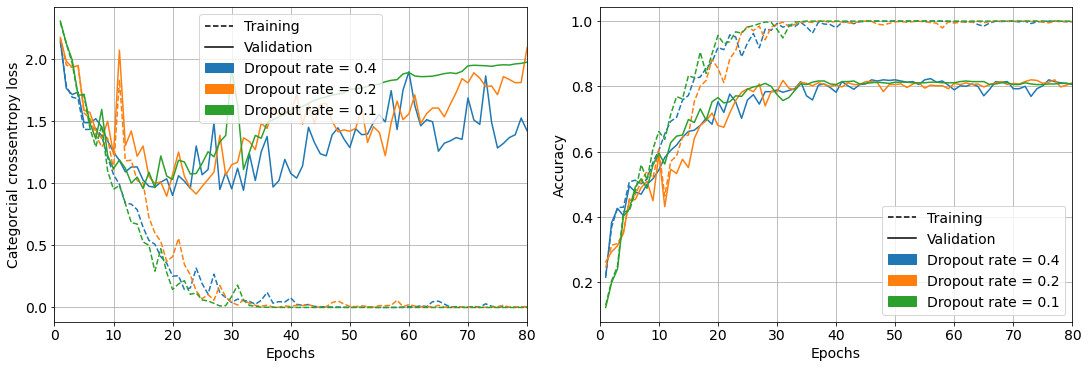

In [53]:
label_strings = []
N = 3
for row_idx, row_series in resultsDF.head(N).iterrows():
    label_strings.append(f"Dropout rate = {row_series['dropout']}")

fig = plot_topN_history_from_df(resultsDF, N, label_strings)
fig.savefig(path + "performance_plots/dropout.pdf")
fig.show()

0.4 Dropout performs the best, but the best accuracy did not improve compared the previous Grid Search (with 0 Dropout). Therefore, the results seem to be highly unstable and a decision should not be made befor trying a different regularizer.

## Try L2-Regularization

In [ ]:
nb_epoch = 80 # strong regularization needs longer training

param_space = {
    'num_filters': [48],
    'kernal_size': [4],
    'dense_nodes': [128],
    'dropout': [0.0],
    'l2_rate': [0.0, 1e-6, 1e-5, 1e-4, 1e-3]
}

value_combis = itertools.product(*[v for v in param_space.values()])
param_combis = [{key:value for key, value in zip(param_space.keys(), combi)} for combi in value_combis]
print(f"Es werden {len(param_combis)} Parameterkombination getestet.")

Es werden 5 Parameterkombination getestet.


In [ ]:
search_results = []

for idx, params in enumerate(param_combis):
    print(f"Starte Run {idx+1}/{len(param_combis)} mit den Parameteren: {params}")

    string_config = ""
    for key, value in params.items():
        string_config += "_" + key + "=" + str(value)

    # save best model according to validation accuracy
    filepath = path + f"Regularization/paramsearch{string_config}.hdf5"
    checkpoint = ModelCheckpoint(
        filepath, monitor="val_accuracy", verbose=0, save_best_only=True, mode="max"
    )

    model = build_model_from_params(params)
    
    # train the model
    fit_results = model.fit(
        x = X_train, y = y_train, 
        batch_size = batch_size, epochs = nb_epoch, 
        validation_data = (X_val, y_val), 
        callbacks = [checkpoint],#, HistoryEpoch((X_train, y_train))], ?!?!
        verbose = 0
    )

    # extract the best validation scores
    best_val_epoch    = np.argmax(fit_results.history['val_accuracy'])
    best_val_acc      = np.max(fit_results.history['val_accuracy'])
    best_val_acc_loss = fit_results.history['val_loss'][best_val_epoch]

    # get correct training accuracy
    best_val_acc_train_loss = fit_results.history['loss'][best_val_epoch]
    best_val_acc_train_acc =  fit_results.history['accuracy'][best_val_epoch]

    # store results
    search_results.append({
        **params,
        'best_val_acc': best_val_acc,
        'best_val_loss': best_val_acc_loss,
        'best_train_acc': best_val_acc_train_acc,
        'best_train_loss': best_val_acc_train_loss,
        'best_val_epoch': best_val_epoch,
        'history': fit_results.history
    })


resultsDF = pd.DataFrame(search_results)
resultsDF.to_hdf(path + "results_regularization_l2.h5", key="results")

Starte Run 1/5 mit den Parameteren: {'num_filters': 48, 'kernal_size': 4, 'dense_nodes': 128, 'dropout': 0.0, 'l2_rate': 0.0}
Starte Run 2/5 mit den Parameteren: {'num_filters': 48, 'kernal_size': 4, 'dense_nodes': 128, 'dropout': 0.0, 'l2_rate': 1e-06}
Starte Run 3/5 mit den Parameteren: {'num_filters': 48, 'kernal_size': 4, 'dense_nodes': 128, 'dropout': 0.0, 'l2_rate': 1e-05}
Starte Run 4/5 mit den Parameteren: {'num_filters': 48, 'kernal_size': 4, 'dense_nodes': 128, 'dropout': 0.0, 'l2_rate': 0.0001}
Starte Run 5/5 mit den Parameteren: {'num_filters': 48, 'kernal_size': 4, 'dense_nodes': 128, 'dropout': 0.0, 'l2_rate': 0.001}


/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:2449: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['history'], dtype='object')]

  encoding=encoding,


In [54]:
#resultsDF = pd.read_hdf(path + "results_regularization_l2.h5", key="results")
resultsDF.sort_values('best_val_acc', ascending=False, inplace=True)
resultsDF

,num_filters,kernal_size,dense_nodes,dropout,l2_rate,best_val_acc,best_val_loss,best_train_acc,best_train_loss,best_val_epoch,history
2,48,4,128,0.0,0.000010,0.825771,1.733173,1.000000,0.017236,47,"{'loss': [2.4308340549468994, 2.14202260971069..."
0,48,4,128,0.0,0.000000,0.823956,1.346761,0.998055,0.011413,26,"{'loss': [2.3916280269622803, 2.10800123214721..."
1,48,4,128,0.0,0.000001,0.814882,1.718368,1.000000,0.002815,42,"{'loss': [2.3444132804870605, 2.17528390884399..."
4,48,4,128,0.0,0.001000,0.807622,1.682586,0.987553,0.280921,62,"{'loss': [3.1628334522247314, 2.60312175750732..."
3,48,4,128,0.0,0.000100,0.787659,1.532449,0.986776,0.112141,33,"{'loss': [2.480170488357544, 2.172370195388794..."


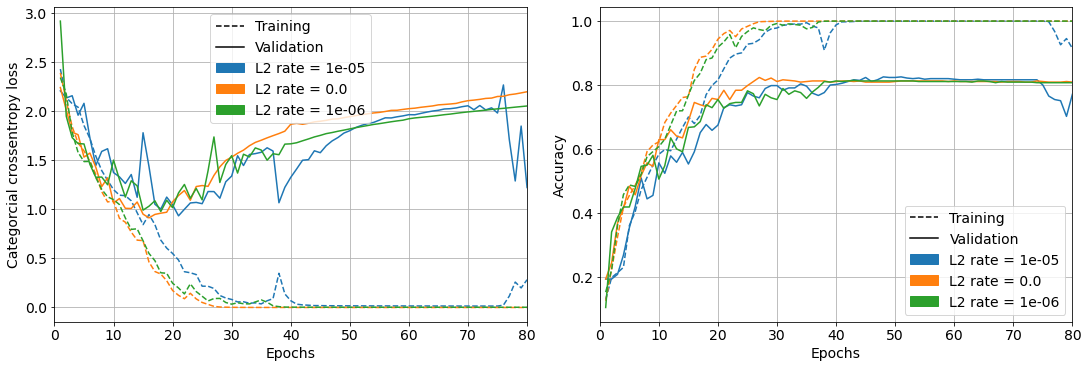

In [59]:
label_strings = []
N = 3
for row_idx, row_series in resultsDF.head(N).iterrows():
    label_strings.append(f"L2 rate = {row_series['l2_rate']}")

fig = plot_topN_history_from_df(resultsDF, N, label_strings)
fig.savefig(path + "performance_plots/l2.pdf")
fig.show()

## Final search for L2 and dropout combination

In [ ]:
nb_epoch = 60 # seems to be enough

param_space = {
    'num_filters': [48],
    'kernal_size': [4],
    'dense_nodes': [128],
    'dropout': [0.0, 0.1, 0.2, 0.3, 0.4],
    'l2_rate': [1e-5]
}

value_combis = itertools.product(*[v for v in param_space.values()])
param_combis = [{key:value for key, value in zip(param_space.keys(), combi)} for combi in value_combis]
print(f"Es werden {len(param_combis)} Parameterkombination getestet.")

Es werden 5 Parameterkombination getestet.


In [ ]:
search_results = []

for idx, params in enumerate(param_combis):
    print(f"Starte Run {idx+1}/{len(param_combis)} mit den Parameteren: {params}")

    string_config = ""
    for key, value in params.items():
        string_config += "_" + key + "=" + str(value)

    # save best model according to validation accuracy
    filepath = path + f"Regularization/paramsearch{string_config}.hdf5"
    checkpoint = ModelCheckpoint(
        filepath, monitor="val_accuracy", verbose=0, save_best_only=True, mode="max"
    )

    model = build_model_from_params(params)
    
    # train the model
    fit_results = model.fit(
        x = X_train, y = y_train, 
        batch_size = batch_size, epochs = nb_epoch, 
        validation_data = (X_val, y_val), 
        callbacks = [checkpoint, HistoryEpoch((X_train, y_train))],
        verbose = 0
    )

    # extract the best validation scores
    best_val_epoch    = np.argmax(fit_results.history['val_accuracy'])
    best_val_acc      = np.max(fit_results.history['val_accuracy'])
    best_val_acc_loss = fit_results.history['val_loss'][best_val_epoch]

    # get correct training accuracy
    best_val_acc_train_loss = fit_results.history['loss'][best_val_epoch]
    best_val_acc_train_acc =  fit_results.history['accuracy'][best_val_epoch]

    # store results
    search_results.append({
        **params,
        'best_val_acc': best_val_acc,
        'best_val_loss': best_val_acc_loss,
        'best_train_acc': best_val_acc_train_acc,
        'best_train_loss': best_val_acc_train_loss,
        'best_val_epoch': best_val_epoch,
        'history': fit_results.history
    })


resultsDF = pd.DataFrame(search_results)
resultsDF.to_hdf(path + "results_regularization_comb.h5", key="results")

Starte Run 1/5 mit den Parameteren: {'num_filters': 48, 'kernal_size': 4, 'dense_nodes': 128, 'dropout': 0.0, 'l2_rate': 1e-05}
Starte Run 2/5 mit den Parameteren: {'num_filters': 48, 'kernal_size': 4, 'dense_nodes': 128, 'dropout': 0.1, 'l2_rate': 1e-05}
Starte Run 3/5 mit den Parameteren: {'num_filters': 48, 'kernal_size': 4, 'dense_nodes': 128, 'dropout': 0.2, 'l2_rate': 1e-05}
Starte Run 4/5 mit den Parameteren: {'num_filters': 48, 'kernal_size': 4, 'dense_nodes': 128, 'dropout': 0.3, 'l2_rate': 1e-05}
Starte Run 5/5 mit den Parameteren: {'num_filters': 48, 'kernal_size': 4, 'dense_nodes': 128, 'dropout': 0.4, 'l2_rate': 1e-05}


/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:2449: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['history'], dtype='object')]

  encoding=encoding,


In [60]:
#resultsDF = pd.read_hdf(path + "results_regularization_comb.h5", key="results")
resultsDF.sort_values('best_val_acc', ascending=False, inplace=True)
resultsDF

,num_filters,kernal_size,dense_nodes,dropout,l2_rate,best_val_acc,best_val_loss,best_train_acc,best_train_loss,best_val_epoch,history
3,48,4,128,0.3,0.00001,0.843920,1.407763,0.999222,0.023193,57,"{'loss': [2.1906087398529053, 2.11879634857177..."
4,48,4,128,0.4,0.00001,0.822142,1.158177,0.999222,0.029775,58,"{'loss': [2.155456781387329, 2.100778818130493..."
2,48,4,128,0.2,0.00001,0.820327,1.327215,0.999222,0.026264,47,"{'loss': [2.3942062854766846, 1.98192632198333..."
1,48,4,128,0.1,0.00001,0.809437,1.578371,0.994555,0.041427,49,"{'loss': [2.3226354122161865, 2.08756160736084..."
0,48,4,128,0.0,0.00001,0.800363,1.408220,0.993388,0.051754,28,"{'loss': [2.1857919692993164, 2.19830846786499..."


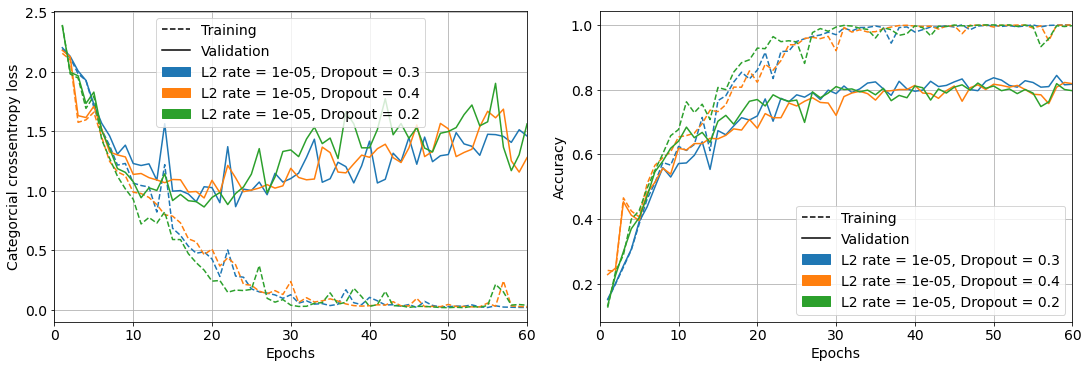

In [62]:
label_strings = []
N = 3
for row_idx, row_series in resultsDF.head(N).iterrows():
    label_strings.append(f"L2 rate = {row_series['l2_rate']}, Dropout = {row_series['dropout']}")

fig = plot_topN_history_from_df(resultsDF, N, label_strings)
fig.savefig(path + "performance_plots/dropout_l2.pdf")
fig.show()

# Optimal hyperparameters and test scores
- batch size = 128 and learning rate = 0.001 (default)
- 5 convolutioal layers with MaxPooling after each layer
- (48, 96, 192, 384, 768) filters for convolutional layers
- 4 x 4 kernals in all convolutional layers
- 1 hidden dense layer with 128 nodes
- $10^{-5}$ L2-regularization in each layer and $30\%$ dropout before the hidden dense layer (no dropout between hidden dense layer and output layer, as there are too few weights between those layers).

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 197, 197, 48)      2352      
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 98, 98, 48)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 95, 95, 96)        73824     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 47, 47, 96)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 44, 44, 192)       295104    
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 22, 22, 192)       0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 19, 19, 384)      

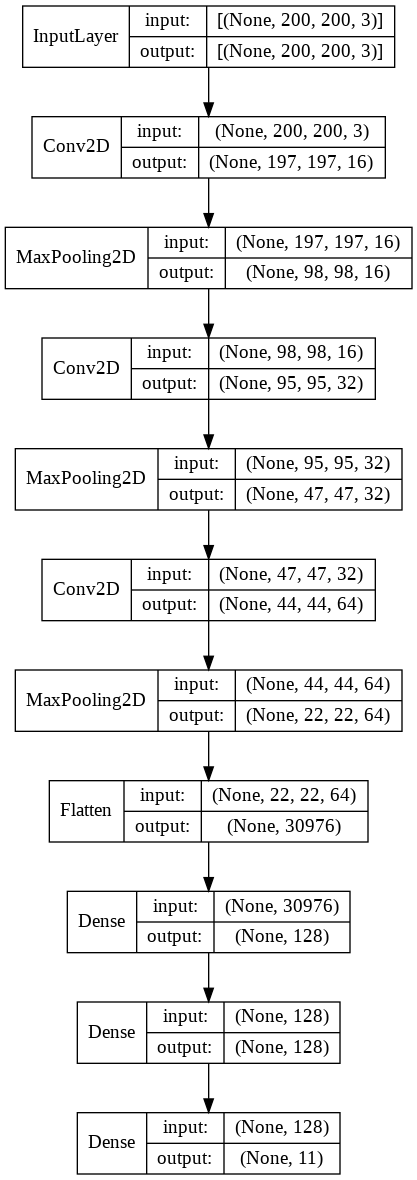

In [63]:
best_model = load_model(path + "Regularization/paramsearch_num_filters=48_kernal_size=4_dense_nodes=128_dropout=0.3_l2_rate=1e-05.hdf5")
best_model.summary()

plot_model(model, to_file=path+"best_model.png", show_shapes=True, show_layer_names=False)
Image(path+"best_model.png")

In [ ]:
with h5py.File(path + "images_resized_test.h5", "r") as file:
    X_test = np.array(file["/images"]).astype("float32")
    y_test = np.array(file["/labels"]).astype("uint8")
  
y_test = to_categorical(y_test, num_classes)

X_test.shape, y_test.shape

((552, 200, 200, 3), (552, 11))

Test Loss: 1.5847187042236328
Test Accuracy: 0.7989130616188049
Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.76      0.73        50
           1       0.92      0.88      0.90        50
           2       0.89      0.80      0.84        50
           3       0.85      0.76      0.80        51
           4       0.75      0.66      0.70        50
           5       0.76      0.74      0.75        50
           6       0.80      0.92      0.85        51
           7       0.85      1.00      0.92        50
           8       0.82      0.62      0.70        50
           9       0.83      0.86      0.84        50
          10       0.67      0.78      0.72        50

    accuracy                           0.80       552
   macro avg       0.80      0.80      0.80       552
weighted avg       0.80      0.80      0.80       552



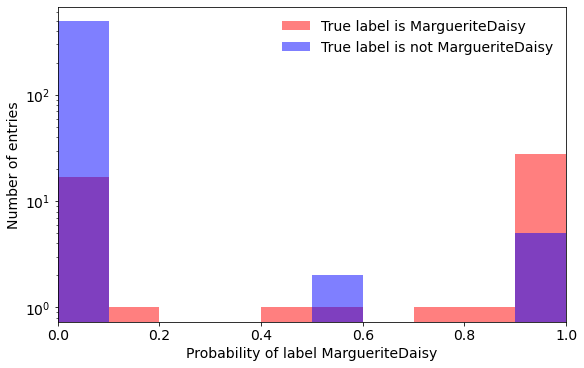

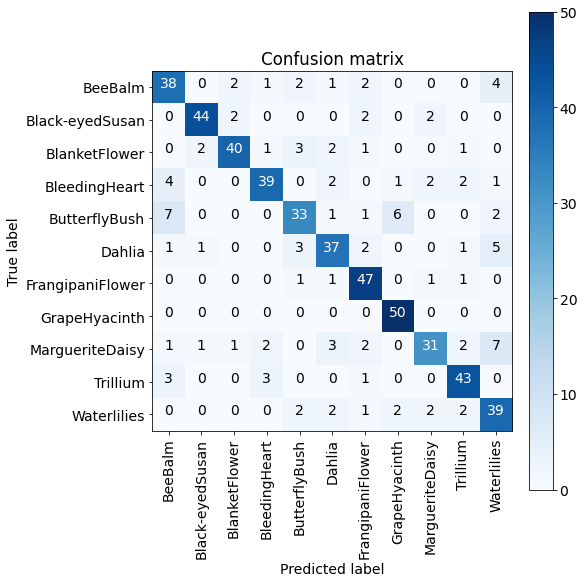

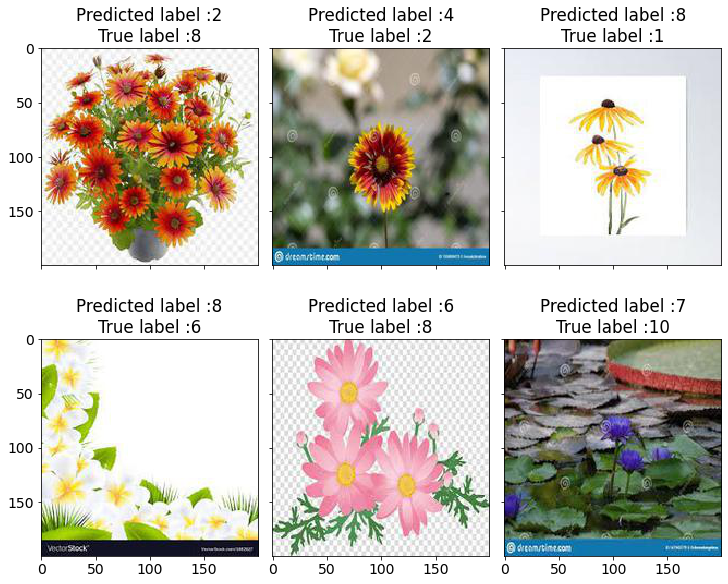

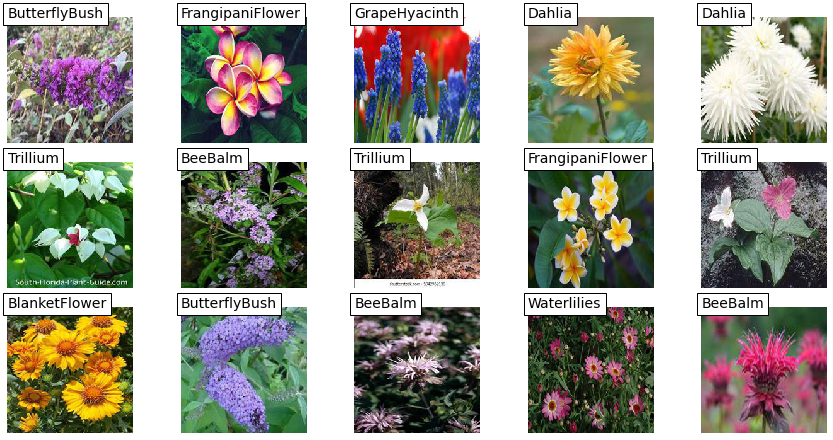

In [ ]:
evaluate(best_model, X_test, y_test, 8, save=True, save_folder=path+"eval_plots_test")

# Cross-validation - Did not run until now

In [ ]:
param_space = {
    'num_filters': [48],
    'kernal_size': [4],
    'dropout': [0.3],
    'dense_nodes': [128]
}

k_folds = 3

value_combis = itertools.product(*[v for v in param_space.values()])
param_combis = [{key:value for key, value in zip(param_space.keys(), combi)} for combi in value_combis]
print(f"Es werden {len(param_combis)} Parameterkombination mit je {k_folds} Kreuzvalidierungsschritten getestet.")

Es werden 3 Parameterkombination mit je 5 Kreuzvalidierungsschritten getestet.


In [ ]:
from sklearn.model_selection import StratifiedKFold

search_results = []

for idx, params in enumerate(param_combis):
    print(f"Starte Run {idx+1}/{len(param_combis)} mit den Parameteren: {params}")

    kf = StratifiedKFold(n_splits=k_folds)

    best_val_accs             = []
    best_val_acc_losses       = []
    best_val_acc_train_accs   = []
    best_val_acc_train_losses = []
    best_val_epochs           = []

    # One-hot Vektoren in Labels umwandlen für stratifed split
    y_labels = np.argmax(y, axis=1)
    for k_idx, (train_idx, val_idx) in enumerate(kf.split(X, y_labels)):
        X_train_cv, X_val_cv = X[train_idx], X[val_idx]
        y_train_cv, y_val_cv = y[train_idx], y[val_idx]
        
        string_config = ""
        for key, value in params.items():
            string_config += "_" + key + "=" + str(value)

        # save best model according to validation accuracy
        filepath = path + f"CV/paramsearch_fold={k_idx}{string_config}.hdf5"
        checkpoint = ModelCheckpoint(
            filepath, monitor="val_accuracy", verbose=0, save_best_only=True, mode="max"
        )

        model = build_model_from_params(params)

        fit_results = model.fit(
            x = X_train_cv, y = y_train_cv,
            batch_size = batch_size, epochs = nb_epoch,
            validation_data = (X_val_cv, y_val_cv),
            callbacks = [checkpoint, early_stop],
            verbose = 0
        )

        # extract the best validation scores
        best_val_epochs.append(np.argmax(fit_results.history['val_accuracy']))
        best_val_accs.append(np.max(fit_results.history['val_accuracy']))
        best_val_acc_losses.append(fit_results.history['val_loss'][best_val_epochs[-1]])
    
        # get correct training accuracy
        best_model = load_model(filepath)
        best_val_acc_train_loss, best_val_acc_train_acc = best_model.evaluate(X_train_cv, y_train_cv)
        best_val_acc_train_accs.append(best_val_acc_train_acc)
        best_val_acc_train_losses.append(best_val_acc_train_loss)

    # store averaged results
    search_results.append({
        **params,
        'best_val_acc': np.mean(best_val_accs),
        'best_val_acc_sem': np.std(best_val_accs) / np.sqrt(k_folds),
        'best_val_loss': np.mean(best_val_acc_losses),
        'best_val_loss_sem': np.std(best_val_acc_losses) / np.sqrt(k_folds),
        'best_train_acc': np.mean(best_val_acc_train_accs),
        'best_train_acc_sem': np.std(best_val_acc_train_accs) / np.sqrt(k_folds),
        'best_train_loss': np.mean(best_val_acc_train_losses),
        'best_train_loss': np.std(best_val_acc_train_losses) / np.sqrt(k_folds),
        'best_val_epoch_fold': best_val_epochs
    })


resultsDF = pd.DataFrame(search_results)
resultsDF.to_hdf(path + "results_CV.h5", key="results")

Starte Run 1/3 mit den Parameteren: {'num_filters': [64, 48, 36], 'kernal_size': 3, 'dropout': 0.5, 'dense_nodes': 96}
79/79 [==============================] - 3s 34ms/step - loss: 0.0634 - accuracy: 0.9852
Starte Run 2/3 mit den Parameteren: {'num_filters': [64, 48, 36], 'kernal_size': 4, 'dropout': 0.5, 'dense_nodes': 96}
79/79 [==============================] - 4s 43ms/step - loss: 0.0475 - accuracy: 0.9956
